## XGB Base Model for Speech Emotion Recognitioin

Import Required Libraries

In [49]:
import pandas as pd 
import librosa
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

Import Dataset 
* Make sure that the dataset is downsampled and augmented using the scripts provided

In [16]:
df = pd.read_csv("../../.././augment/train.csv")

Encode emotions to numeric values

In [17]:
label_encoder = LabelEncoder()
df["Emotion_Code"] = label_encoder.fit_transform(df["Emotions"])

In [18]:
df.head()

,Path,Emotions,Emotion_Code
0,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,disgust,1
1,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,fear,2
2,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,happy,3
3,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,happy,3
4,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,neutral,4


Feature Extraction (Work in Progress)
* Currently consiering mfcc, chroma and contrast

In [19]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast_mean = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    # zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y))

    features = {}
    for i in range(13):
        features[f'mfccs_mean_{i}'] = mfccs_mean[i]
    for i in range(12):
        features[f'chroma_mean_{i}'] = chroma_mean[i]
    for i in range(7):
        features[f'contrast_mean_{i}'] = contrast_mean[i]
    # features["zcr"] = zcr_mean
    return features

tqdm.pandas(desc="Extracting Features")

features_list = df['Path'].progress_apply(extract_features).tolist()
features_df = pd.DataFrame(features_list)

df = pd.concat([df, features_df], axis=1)

Extracting Features:  25%|██▌       | 13836/54459 [05:06<17:21, 39.00it/s]f:\anaconda3\envs\fusemachines\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features: 100%|██████████| 54459/54459 [19:24<00:00, 46.75it/s]


In [27]:
df.to_csv("features.csv", index = False)

In [28]:
df.head()

,Path,Emotions,Emotion_Code,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,...,chroma_mean_9,chroma_mean_10,chroma_mean_11,contrast_mean_0,contrast_mean_1,contrast_mean_2,contrast_mean_3,contrast_mean_4,contrast_mean_5,contrast_mean_6
0,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,disgust,1,-372.189270,110.652802,42.507835,19.978947,8.873278,6.390645,-2.274647,...,0.579746,0.683010,0.422225,14.741636,14.464082,16.659491,16.062239,16.783176,16.641358,14.961041
1,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,fear,2,-495.466736,107.260826,44.240742,20.554245,12.766783,12.086821,-3.935520,...,0.377164,0.533897,0.700226,17.419035,16.573568,17.568819,16.982084,16.903808,16.963365,23.680593
2,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,happy,3,-389.617065,105.263855,19.118555,24.620436,7.091155,6.397869,2.575613,...,0.448337,0.457364,0.304401,16.404687,17.402086,20.568302,18.559537,17.678943,18.215816,15.700979
3,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,happy,3,-328.358704,112.218132,12.635479,19.407642,1.724487,4.177226,1.830498,...,0.372623,0.372768,0.288887,14.833523,16.842459,18.547187,17.716576,18.872019,19.711620,14.332736
4,D:\Fuse Machines AI Fellowship\ASR-with-Speech...,neutral,4,-337.352173,115.282990,25.985569,24.516438,3.753398,-1.843750,2.464512,...,0.629278,0.571712,0.309233,15.737115,15.829539,19.489688,17.378145,15.948800,19.299600,14.766174


Create trainng and testing sets

In [21]:
X = df.drop(columns=['Path', 'Emotions', 'Emotion_Code'], axis = 1)
y = df['Emotion_Code']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create XGB model and train

In [36]:
model = xgb.XGBClassifier(
    objective='multi:softprob',  
    max_depth=5,  
    learning_rate=0.1,  
    n_estimators=500,  
    num_class=len(y.unique()) 
)

In [37]:
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [50]:
joblib.dump(model, "model.pkl")

['model.pkl']

Model evaluation

In [38]:
y_pred = model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 70.34%
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1759
           1       0.66      0.62      0.64      1783
           2       0.71      0.60      0.65      1750
           3       0.66      0.63      0.65      1686
           4       0.65      0.73      0.69      1649
           5       0.70      0.76      0.73      1756
           6       0.93      0.89      0.91       509

    accuracy                           0.70     10892
   macro avg       0.73      0.72      0.72     10892
weighted avg       0.70      0.70      0.70     10892



In [48]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

Confusion Matrix:


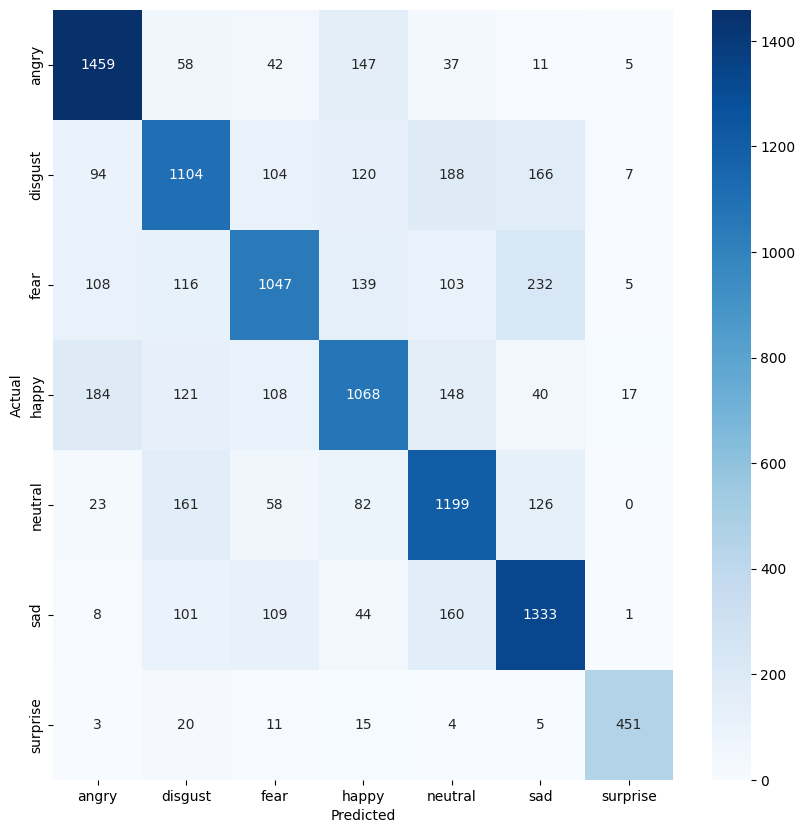

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap = "Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
